In [3]:
from huggingface_hub import list_datasets

all_datasets=[ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터 셋이 있습니다.")
print(f"처음 10개의 데이터 셋 : {all_datasets[:10]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


현재 허브에는 149044개의 데이터 셋이 있습니다.
처음 10개의 데이터 셋 : ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [1]:
!pip install datasets
from datasets import load_dataset

# "emotion" 데이터셋 로드
emotions = load_dataset("emotion")

# 데이터셋 정보 출력
print(emotions)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
train_ds=emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

In [ ]:
train_ds[0]

In [ ]:
print(train_ds.features)

In [3]:
import pandas as pd

emotions.set_format(type="pandas")
df=emotions["train"][:]
df.head(n=10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [4]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"]=df["label"].apply(label_int2str)
df.head(n=10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


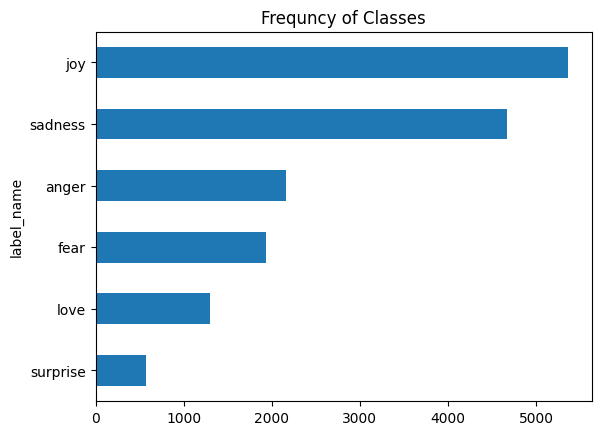

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequncy of Classes")
plt.show()

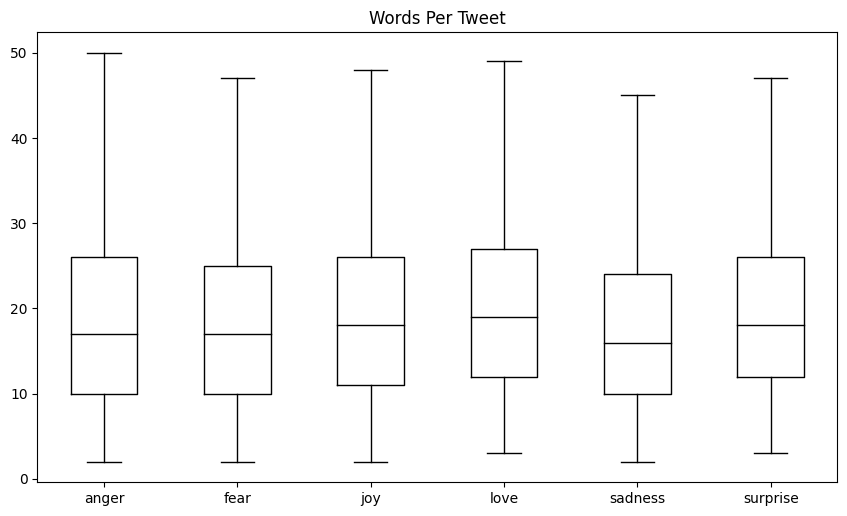

In [ ]:
df["Words Per Tweet"]=df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, figsize=(10,6),color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotions.reset_format()

In [ ]:
from transformers import AutoTokenizer

model_checkpoint="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
text="This is OSSP project!!"
encoded_text=tokenizer(text)
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)


['[CLS]', 'this', 'is', 'os', '##sp', 'project', '!', '!', '[SEP]']


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded=emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModel
import torch

model_ckpt="distilbert-base-uncased"
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model=AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
text="This is OSSP project!!"
inputs=tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기 : {inputs['input_ids'].size()}")

입력 텐서 크기 : torch.Size([1, 9])


In [ ]:
inputs={k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs=model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0487, -0.1781,  0.1206,  ..., -0.1821,  0.2511,  0.4629],
         [-0.4378, -0.5580,  0.0774,  ..., -0.4897,  0.4643,  0.2860],
         [-0.3811, -0.3867,  0.2719,  ..., -0.1304,  0.3742,  0.8226],
         ...,
         [ 0.2097, -0.1491,  0.2754,  ...,  0.0782,  0.0489,  0.1769],
         [ 0.0160, -0.3612,  0.0923,  ...,  0.1112,  0.0344,  0.0661],
         [ 0.7826,  0.1128, -0.4700,  ...,  0.1986, -0.6693, -0.3002]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 9, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
  inputs={k:v.to(device) for k,v in batch.items()
      if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state=model(**inputs).last_hidden_state
  return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}


In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden=emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

X_train=np.array(emotions_hidden["train"]["hidden_state"])
X_valid=np.array(emotions_hidden["validation"]["hidden_state"])
y_train=np.array(emotions_hidden["train"]["label"])
y_valid=np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 예제 데이터 로드
# X_train과 y_train을 예제로 사용합니다.

# 데이터 스케일링
X_scaled = MinMaxScaler().fit_transform(X_train)

# UMAP 적용
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# 결과를 데이터프레임으로 변환
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

# 결과 출력
print(df_emb.head())


ModuleNotFoundError: No module named 'umap'

NameError: name 'df_emb' is not defined

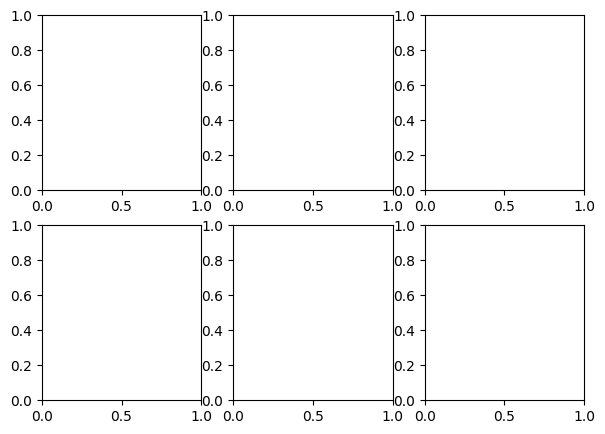

In [ ]:
fig,axes=plt.subplots(2,3,figsize=(7,5))
axes=axes.flatten()
cmaps=["Greys","Blues","Oranges","Reds","Purples","Greens"]
labels=emotions["train"].features["label"].names

for i, (label,cmap) in enumerate(zip(labels,cmaps)):
  df_emb_sub=df_emb.query(f"label=={i}")
  axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"],cmap=cmap,gridsize=20,linewidth=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.634

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

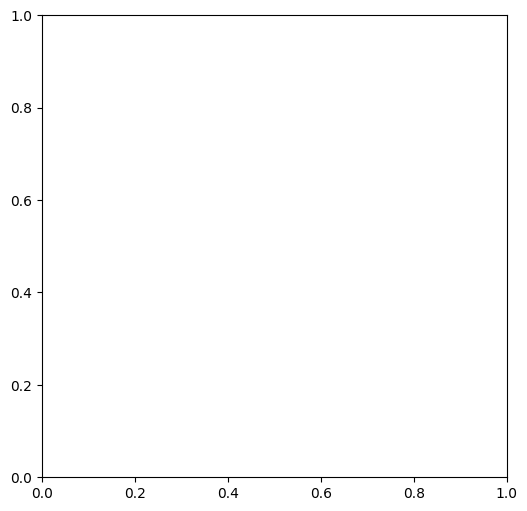

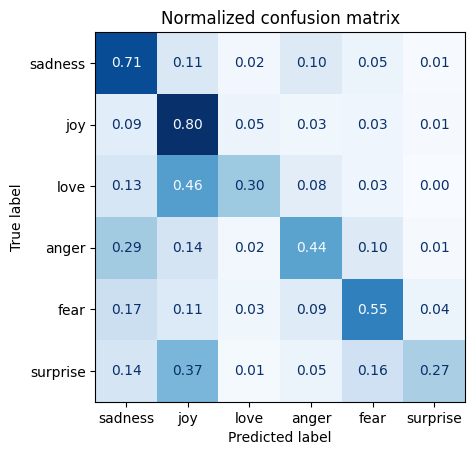

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

def plot_confusion_matrix(y_preds,y_true,labels):
  cm=confusion_matrix(y_true,y_preds,normalize="true")
  fig,ax=plt.subplots(figsize=(6,6))
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap="Blues",values_format=".2f",colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels=6
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:


# Hugging Face Hub 로그인
from huggingface_hub import notebook_login
notebook_login()


In [ ]:

# 데이터셋 로드
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

emotions = load_dataset("emotion")

# 토크나이저 및 모델 설정
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=6).to(device)

# 토큰화 함수 정의
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# 데이터셋 토큰화
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# 데이터셋 형식 설정
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 훈련 및 평가 데이터셋 설정
train_dataset = emotions_encoded["train"]
eval_dataset = emotions_encoded["validation"]

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,  # 모델을 허브에 업로드할 수 있도록 설정
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

)

# 모델 훈련
trainer.train()

# 모델 허브에 업로드
trainer.push_to_hub(commit_message="Training completed!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Some weig

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.249700,0.202700
2,0.149100,0.166948
3,0.091600,0.155397


events.out.tfevents.1716110367.fa6f5f39d06e.3829.0:   0%|          | 0.00/7.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/forwarder1121/results/commit/950a09bc28674ab047a8e07df2dc7b5f110cc039', commit_message='Training completed!', commit_description='', oid='950a09bc28674ab047a8e07df2dc7b5f110cc039', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
model_id="forwarder1121/results"
classifier=pipeline("text-classification",model=model_id)

custom_text="OSSP is so funny"
preds=classifier(custom_text,top_k=None)

preds_sorted=sorted(preds,key=lambda d: d["label"])
preds_df=pd.DataFrame(preds_sorted)


In [ ]:
from transformers import AutoTokenizer

# 모델 경로
model_checkpoint = "distilbert-base-uncased"
save_directory = "./tokenizer"

# 토크나이저 로드 및 저장
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.save_pretrained(save_directory)


('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [ ]:
from huggingface_hub import HfApi, HfFolder

# Hugging Face Hub에 로그인
api = HfApi()
token = HfFolder.get_token()  # 이미 로그인한 경우 토큰을 가져옴

# 모델 저장소 정보
model_id = "forwarder1121/results"
save_directory = "./tokenizer"

# 파일 업로드
api.upload_folder(
    folder_path=save_directory,
    path_in_repo="",
    repo_id=model_id,
    repo_type="model",
    token=token
)


CommitInfo(commit_url='https://huggingface.co/forwarder1121/results/commit/2335cf403fe774c6f020d2ab3c83e0877160b3f0', commit_message='Upload folder using huggingface_hub', commit_description='', oid='2335cf403fe774c6f020d2ab3c83e0877160b3f0', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!python --version

Python 3.10.12


In [6]:
import json
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from huggingface_hub import HfApi, hf_hub_download

# 1. 레이블 이름 저장
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
label_names_path = "label_names.json"
with open(label_names_path, "w") as f:
    json.dump(label_names, f)

# 2. 모델 ID 설정
model_id = "forwarder1121/results"

# 3. 레이블 이름 파일 업로드
api = HfApi()
api.upload_file(
    path_or_fileobj=label_names_path,
    path_in_repo="label_names.json",
    repo_id=model_id,
    repo_type="model",
)

# 4. 모델 다시 업로드
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

# 5. 모델 및 레이블 이름 로드
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
label_names_path = hf_hub_download(repo_id=model_id, filename="label_names.json")
with open(label_names_path, "r") as f:
    label_names = json.load(f)

# 레이블 이름 변환 함수
def get_label_name(label_index):
    return label_names[label_index]

# 분류 파이프라인 설정
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 테스트 문장
custom_text = "OSSP is very funny"
result = classifier(custom_text)

# 결과 출력 (감정 이름으로 변환)
for res in result:
    label_index = int(res['label'].split('_')[-1])  # 'LABEL_0' 형태에서 숫자 부분 추출
    res['label'] = get_label_name(label_index)
    print(f"Text: {custom_text}")
    print(f"Predicted Emotion: {res['label']}, with score: {res['score']:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

label_names.json:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

Text: OSSP is very funny
Predicted Emotion: surprise, with score: 0.7579


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from huggingface_hub import hf_hub_download, HfApi
import json

# 1. 레이블 이름 저장
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
label_names_path = "label_names.json"
with open(label_names_path, "w") as f:
    json.dump(label_names, f)

# 2. 모델 ID 설정
model_id = "forwarder1121/results"

# 3. 레이블 이름 파일 업로드
api = HfApi()
api.upload_file(
    path_or_fileobj=label_names_path,
    path_in_repo="label_names.json",
    repo_id=model_id,
    repo_type="model",
)

# 4. 모델 및 토크나이저 다시 업로드
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

# 5. 모델 및 레이블 이름 로드
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
label_names_path = hf_hub_download(repo_id=model_id, filename="label_names.json")
with open(label_names_path, "r") as f:
    label_names = json.load(f)

# 레이블 이름 변환 함수
def get_label_name(label_index):
    return label_names[label_index]

# 분류 파이프라인 설정
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 테스트 문장
custom_text = "I like you. I love you"
results = classifier(custom_text)

# 결과 출력 (감정 이름으로 변환)
for res in results:
    label_index = int(res['label'].split('_')[-1])  # 'LABEL_0' 형태에서 숫자 부분 추출
    res['label'] = get_label_name(label_index)
    print(f"Text: {custom_text}")
    print(f"Predicted Emotion: {res['label']}, with score: {res['score']:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text: I like you. I love you
Predicted Emotion: love, with score: 0.9278


In [10]:
import json
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import HfApi

# 레이블 이름 정의
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# 모델 ID 설정
model_id = "forwarder1121/results"

# 모델 구성 로드
config = AutoConfig.from_pretrained(model_id)

# id2label 및 label2id 추가
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: str(i) for i, label in enumerate(label_names)}
config.id2label = id2label
config.label2id = label2id

# 수정된 구성 저장
config_path = "config.json"
with open(config_path, "w") as f:
    json.dump(config.to_dict(), f)

# 구성 파일 업로드
api = HfApi()
api.upload_file(
    path_or_fileobj=config_path,
    path_in_repo="config.json",
    repo_id=model_id,
    repo_type="model",
)

print(f"Updated config.json uploaded to {model_id}.")


config.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

Updated config.json uploaded to forwarder1121/results.


In [11]:
# 모델 및 토크나이저 로드
model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 모델 및 토크나이저 다시 업로드
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

print(f"Model and tokenizer pushed to {model_id}.")


Model and tokenizer pushed to forwarder1121/results.


In [13]:
import json
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import HfApi

# 레이블 이름 정의
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# 모델 ID 설정
model_id = "forwarder1121/results"

# 모델 구성 로드
config = AutoConfig.from_pretrained(model_id)

# id2label 및 label2id 추가
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: str(i) for i, label in enumerate(label_names)}
config.id2label = id2label
config.label2id = label2id

# 수정된 구성 저장
config_path = "config.json"
with open(config_path, "w") as f:
    json.dump(config.to_dict(), f)

# 구성 파일 업로드
api = HfApi()
api.upload_file(
    path_or_fileobj=config_path,
    path_in_repo="config.json",
    repo_id=model_id,
    repo_type="model",
)

print(f"Updated config.json uploaded to {model_id}.")


Updated config.json uploaded to forwarder1121/results.


In [14]:
# 모델 및 토크나이저 로드
model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 모델 및 토크나이저 다시 업로드
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

print(f"Model and tokenizer pushed to {model_id}.")


Model and tokenizer pushed to forwarder1121/results.


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_id = "forwarder1121/results"

# 모델 및 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# 분류 파이프라인 설정
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 테스트 문장
custom_text = "OSSP is very funny"
result = classifier(custom_text)

# 결과 출력 (감정 이름으로 변환)
for res in result:
    print(f"Text: {custom_text}")
    print(f"Predicted Emotion: {res['label']}, with score: {res['score']:.4f}")


Text: OSSP is very funny
Predicted Emotion: surprise, with score: 0.7579


In [16]:
import json
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import HfApi

# 레이블 이름 정의
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# 모델 ID 설정
model_id = "forwarder1121/results"

# 모델 구성 로드
config = AutoConfig.from_pretrained(model_id)

# id2label 및 label2id 추가
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: str(i) for i, label in enumerate(label_names)}
config.id2label = id2label
config.label2id = label2id

# 수정된 구성 저장
config_path = "config.json"
with open(config_path, "w") as f:
    json.dump(config.to_dict(), f)

# 구성 파일 업로드
api = HfApi()
api.upload_file(
    path_or_fileobj=config_path,
    path_in_repo="config.json",
    repo_id=model_id,
    repo_type="model",
)

print(f"Updated config.json uploaded to {model_id}.")


Updated config.json uploaded to forwarder1121/results.


In [17]:
# 모델 및 토크나이저 로드
model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 모델 및 토크나이저 다시 업로드
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

print(f"Model and tokenizer pushed to {model_id}.")


Model and tokenizer pushed to forwarder1121/results.


In [19]:
from transformers import pipeline

model_id = "forwarder1121/results"

# 분류 파이프라인 설정
classifier = pipeline("text-classification", model=model_id, tokenizer=model_id)

# 테스트 문장
custom_text = "love love"
result = classifier(custom_text)

# 결과 출력 (감정 이름으로 변환)
for res in result:
    print(f"Text: {custom_text}")
    print(f"Predicted Emotion: {res['label']}, with score: {res['score']:.4f}")


Text: love love
Predicted Emotion: love, with score: 0.8155


In [1]:
!pip install transformers accelerate -q
!pip install git+https://github.com/huggingface/diffusers@@shap-ee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.8 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers@ (to revision shap-ee) to /tmp/pip-req-build-uoey4bsn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers@ /tmp/pip-req-build-uoey4bsn
  remote: Repository not found.
  fatal: repository 'https://github.com/huggingface/diffusers@/' not found
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers@ /tmp/pip-req-build-uoey4bsn did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers@ /tmp/pip-req-build-uoey4bsn did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and